In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
import tree
import scipy
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation
from omegaconf import OmegaConf
import importlib
import logging
import sys

from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from data import r3_diffuser
from data import r3_diffuser_ddpm
from data import digs_data_loader
from model import loss
from experiments import train_se3_diffusion

# Enable logging
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

INFO: Using numpy backend


In [2]:
wd = scipy.stats.wasserstein_distance

In [3]:
# SDE time parameters
num_t = 1000
forward_t = np.linspace(1e-5, 1, num_t)
reverse_t = forward_t[::-1]
dt = 1 / num_t
n_samples = 1000

In [4]:
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

# Aanalyze both

In [6]:
wd = scipy.stats.wasserstein_distance

# SDE time parameters
num_t = 1000
forward_t = np.linspace(1e-5, 1, num_t)
reverse_t = forward_t[::-1]
dt = 1 / num_t
n_samples = 1000

def trans_wd_schedule(schedule, beta_min, beta_max):
    r3_diff = r3_diffuser.R3Diffuser(
        min_b=beta_min,
        max_b=beta_max,
        schedule=schedule
    )
    
    x_0 = np.zeros((n_samples, 3))
    x_1 = r3_diff.sample_ref(n_samples=n_samples)
    x_1_norm = np.linalg.norm(x_1, axis=-1)
    all_trans_wd = []
    for i,t in enumerate(forward_t):
        x_t, _ = r3_diff.forward_marginal(x_0, t, score_norm=False)
        x_t_norm = np.linalg.norm(x_t, axis=-1)
        wd_t = wd(x_t_norm, x_1_norm)
        all_trans_wd.append(wd_t)
    return all_trans_wd

def rot_wd_schedule(schedule, min_sigma, max_sigma):
    so3_diff = so3_diffuser.SO3Diffuser(
        min_sigma=min_sigma,
        max_sigma=max_sigma,
        schedule=schedule
    )
    
    rot_0 = np.zeros((n_samples, 3))
    rot_1 = so3_diff.sample_ref(n_samples=n_samples)
    rot_1_norm = np.linalg.norm(rot_1, axis=-1)
    all_rot_wd = []
    for i,t in enumerate(forward_t):
        rot_t, _, _ = so3_diff.forward_marginal(rot_0, t)
        rot_t_norm = np.linalg.norm(rot_t, axis=-1)
        wd_t = wd(rot_t_norm, rot_1_norm)
        all_rot_wd.append(wd_t)
    return all_rot_wd

In [7]:
def plot_both_schedules(rot_schedule, trans_schedule, min_sigma=0.1, max_sigma=1.5, min_beta=0.1, max_beta=20.0):
    rot_wd = rot_wd_schedule(rot_schedule, min_sigma, max_sigma)
    rot_wd_name = rf'{rot_schedule} rotation $\sigma_0$={min_sigma}, $\sigma_1$={max_sigma}'
    plt.plot(forward_t, rot_wd, label=rot_wd_name)

    trans_wd = trans_wd_schedule(trans_schedule, min_beta, max_beta)
    trans_wd_name = rf'{trans_schedule} translation $\beta_0$={min_beta}, $\beta_1$={max_beta}'
    plt.plot(forward_t, trans_wd, label=trans_wd_name)

    plt.xlabel('time')
    plt.ylabel('Wasserstein-1')
    plt.title('Comparison of schedules')
    plt.legend()

INFO: Computing IGSO3.


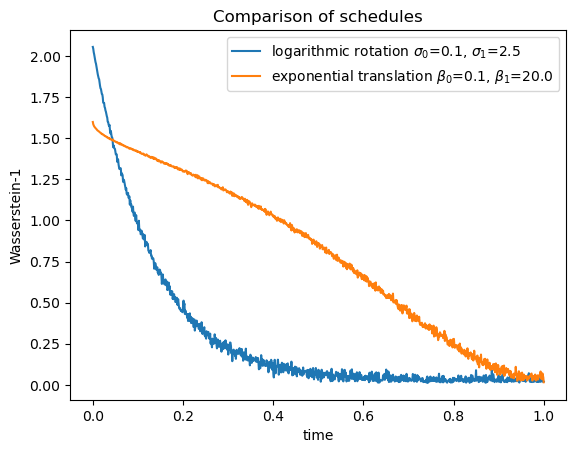

In [11]:
plot_both_schedules('logarithmic', 'exponential', max_sigma=2.5)

INFO: Using cached IGSO3.


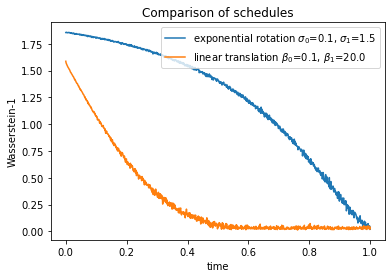

In [52]:
plot_both_schedules('exponential', 'linear')

INFO: Using cached IGSO3.


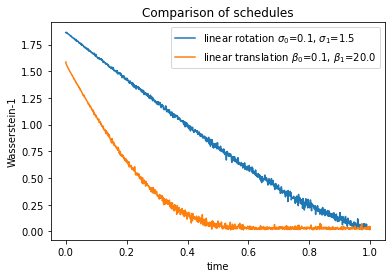

In [53]:
plot_both_schedules('linear', 'linear')

INFO: Using cached IGSO3.


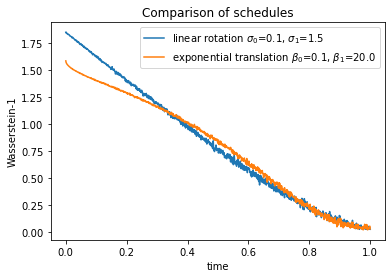

In [54]:
plot_both_schedules('linear', 'exponential')

INFO: Using cached IGSO3.


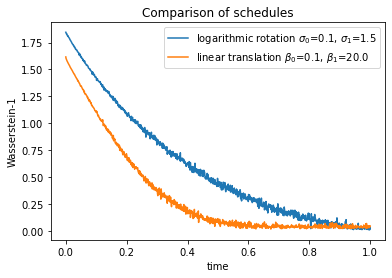

In [55]:
plot_both_schedules('logarithmic', 'linear')

INFO: Using cached IGSO3.


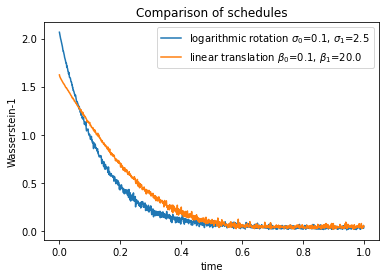

In [56]:
plot_both_schedules('logarithmic', 'linear', max_sigma=2.5)

INFO: Using cached IGSO3.


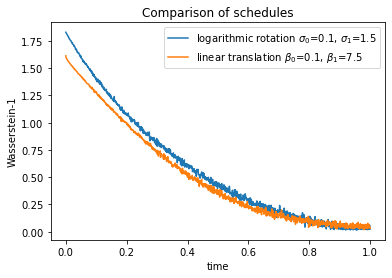

In [57]:
plot_both_schedules('logarithmic', 'linear', max_beta=7.5)

INFO: Using cached IGSO3.


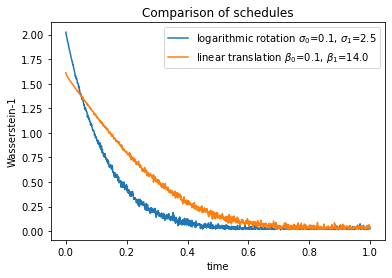

In [61]:
plot_both_schedules('logarithmic', 'linear', max_beta=14.0, max_sigma=2.5)